<a href="https://colab.research.google.com/github/OdysseusPolymetis/colabs_for_nlp/blob/main/3_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyse de Sentiments**

Grâce aux nouveaux modèles d'intelligence artificielle, à savoir dans le cas présent les Transformers, nous pouvons partiellement mesurer les sentiments présents dans un texte.
<br>Attention cependant, il s'agit de sentiments extrêmement primaires pour la plupart (même si certains modèles sont plus spécifiques). Il s'agit, pour celui qu'on va utiliser, de sentiments négatifs, neutres ou positifs.
<br>Le modèle vous donne deux indications, un degré de négativité/neutralité/positivité, ainsi que la confiance en son score.

Ici nous allons faire deux processus (c'est pour cela que le carnet sera un peu répétitif). D'abord nous allons prendre un xml de base tel que vous pourriez le trouver en ligne. Ensuite, nous ferons le même processus pour un texte en plain text, afin que vous puissiez utiliser vos propres textes.

## Partie commune aux deux processus

In [ ]:
!pip install stanza transformers

In [2]:
import os
import stanza
from lxml import etree as ET
import lxml.html
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from transformers import pipeline

In [3]:
# Utilisation de CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du pipeline avec le modèle en utilisant CUDA
sentiment_pipe = pipeline(
    "text-classification",
    model="ac0hik/Sentiment_Analysis_French",
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

Device set to use cuda:0


## Partie pour le cas où vous avez un XML

In [4]:
!wget https://raw.githubusercontent.com/ebalzac/FC/refs/heads/gh-pages/balzac-22-FC-pere-goriot.xml

--2025-02-13 14:08:12--  https://raw.githubusercontent.com/ebalzac/FC/refs/heads/gh-pages/balzac-22-FC-pere-goriot.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 622528 (608K) [text/plain]
Saving to: ‘balzac-22-FC-pere-goriot.xml’

balzac-22-FC-pere-g 100%[===================>] 607.94K  --.-KB/s    in 0.007s  

2025-02-13 14:08:13 (79.8 MB/s) - ‘balzac-22-FC-pere-goriot.xml’ saved [622528/622528]



In [5]:
def strip_ns_prefix(tree):
    query = "descendant-or-self::*[namespace-uri()!='']"
    for element in tree.xpath(query):
        element.tag = ET.QName(element).localname
    return tree

In [6]:
filepath_of_text = "/content/balzac-22-FC-pere-goriot.xml"

In [7]:
nlp_stanza = stanza.Pipeline(lang='fr', processors='tokenize,mwt')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json


INFO:stanza:Loading these models for language: fr (French):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


In [8]:
parser = ET.XMLParser(remove_blank_text=True, resolve_entities=False, encoding='utf8')
tree = strip_ns_prefix(ET.parse(filepath_of_text, parser))
ps = tree.xpath(".//p")
paragraphs= []
for p in ps:
  sentences = []
  for sentence in nlp_stanza("".join(p.itertext())).sentences:
    sentences.append(sentence.text)
  paragraphs.append(sentences)

In [9]:
len(paragraphs)

1558

In [10]:
paragraph_sentiments = []
for paragraph in paragraphs:
    sentence_scores = []
    confidence_scores = []  # Liste pour stocker les scores de confiance

    for sentence in paragraph:
        sentiment = sentiment_pipe(sentence)[0]
        confidence = sentiment['score']
        confidence_scores.append(confidence)

        # Calcul du score de base en fonction de l'étiquette
        if sentiment['label'] == 'negative':
            score = - (confidence - 0.5) * 2  # Score négatif ajusté
        elif sentiment['label'] == 'positive':
            score = (confidence - 0.5) * 2  # Score positif ajusté
        else:  # 'neutral'
            score = 0  # Pas de sentiment

        sentence_scores.append(score)

    # Calcul de la moyenne des scores de sentiment pour le paragraphe
    avg_score = np.mean(sentence_scores)

    # Calcul de la moyenne des scores de confiance
    avg_confidence = np.mean(confidence_scores)

    # Ajustement du score basé sur la longueur du paragraphe
    paragraph_length = len(paragraph)  # Nombre de phrases dans le paragraphe

    # Ajuster l'impact de la longueur et de la confiance de manière plus prononcée
    if paragraph_length > 4:  # Paragraphe long
        adjusted_score = avg_score * (1 + 0.2 * (avg_confidence - 0.5))  # Amplification plus forte
    elif paragraph_length <= 2:  # Paragraphe court
        adjusted_score = avg_score * (1 - 0.2 * (1 - avg_confidence))  # Réduction plus forte
    else:
        adjusted_score = avg_score  # Pas de changement pour les paragraphes de taille moyenne

    paragraph_sentiments.append(adjusted_score)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [11]:
indices_to_print = [30, 240, 930]
for index in indices_to_print:
    if index < len(paragraphs):
        paragraph = paragraphs[index]

        full_paragraph = " ".join(paragraph)

        print(f"\nParagraphe {index}:")
        print(full_paragraph)
        print(f"Score moyen de sentiment: {paragraph_sentiments[index]}")


Paragraphe 30:
Pendant le dîner, madame Vauquer alla tirer un rideau, pour empêcher que Goriot ne fût incommodé par le soleil dont un rayon lui tombait sur les yeux.
Score moyen de sentiment: -0.8035653987667558

Paragraphe 240:
– Ah ! c’est vous, monsieur de Rastignac, je suis bien aise de vous voir, dit-elle d’un air auquel savent obéir les gens d’esprit.
Score moyen de sentiment: 0.2962839771611691

Paragraphe 930:
– Dites donc, monsieur Eugène, s’écria madame Vauquer, vous avez mis la main au bon endroit.
Score moyen de sentiment: 0.5303130527939075


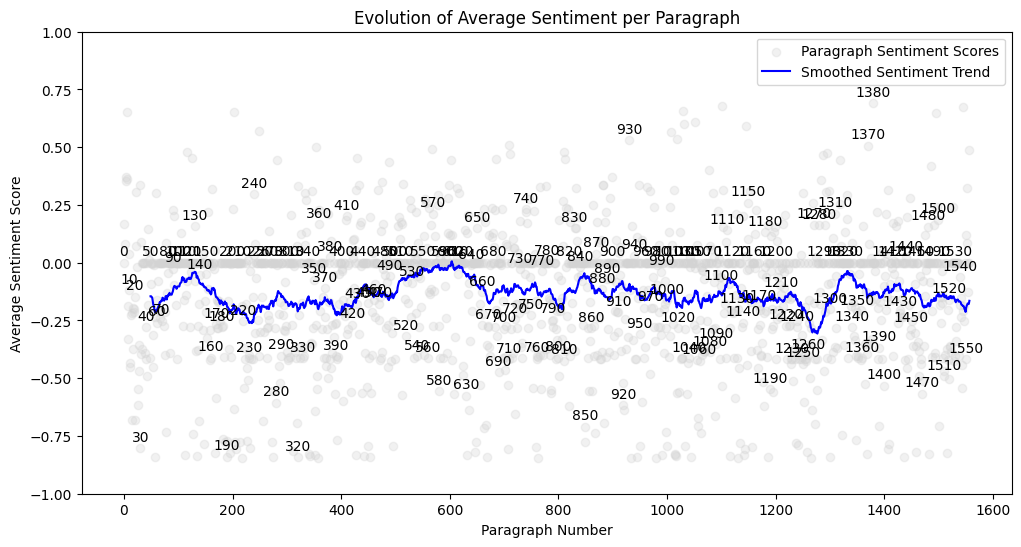

In [12]:
window_size = 50
smoothed_sentiments = np.convolve(paragraph_sentiments, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(12, 6))

plt.scatter(range(len(paragraph_sentiments)), paragraph_sentiments, alpha=0.3, color='lightgray', label='Paragraph Sentiment Scores')

plt.plot(range(window_size - 1, len(paragraph_sentiments)), smoothed_sentiments, color='blue', label='Smoothed Sentiment Trend')

plt.ylim(-1, 1)

plt.xlabel('Paragraph Number')
plt.ylabel('Average Sentiment Score')
plt.title('Evolution of Average Sentiment per Paragraph')
plt.legend()

for i, sentiment in enumerate(paragraph_sentiments):
    if i % 10 == 0:
        plt.annotate(str(i), (i, sentiment), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

In [13]:
def display_paragraphs(indices):
  for i in indices:
    if 0 <= i < len(paragraphs):
      print(f"Paragraph {i}:")
      for sentence in paragraphs[i]:
        print(sentence)
    else:
      print(f"Index {i} is out of bounds.")

display_paragraphs([570])

Paragraph 570:
Depuis cette conversation, le père Goriot vit dans son voisin un confident inespéré, un ami.
Il s’était établi entre eux les seuls rapports par lesquels ce vieillard pouvait s’attacher à un autre homme.
Les passions ne font jamais de faux calculs.
Le père Goriot se voyait un peu plus près de sa fille Delphine, il s’en voyait mieux reçu, si Eugène devenait cher à la baronne.
D’ailleurs il lui avait confié l’une de ses douleurs.
Madame de Nucingen, à laquelle mille fois par jour il souhaitait le bonheur, n’avait pas connu les douceurs de l’amour.
Certes, Eugène était, pour se servir de son expression, un des jeunes gens les plus gentils qu’il eût jamais vus, et il semblait pressentir qu’il lui donnerait tous les plaisirs dont elle avait été privée.
Le bonhomme se prit donc pour son voisin d’une amitié qui alla croissant, et sans laquelle il eût été sans doute impossible de connaître le dénoûment de cette histoire.


In [14]:
display_paragraphs([1370])

Paragraph 1370:
– Bien, dit-elle en lui prenant la main.
Vous êtes peut-être ici le seul auquel je puisse me fier.
Mon ami, aimez une femme que vous puissiez aimer toujours.
N’en abandonnez aucune.


In [15]:
display_paragraphs([320])

Paragraph 320:
Madame de Beauséant sourit, mais tristement : elle sentait déjà le malheur qui grondait dans son atmosphère.


In [16]:
display_paragraphs([230])

Paragraph 230:
– Ah !
bien, sa bêtise est peut-être contagieuse.


In [17]:
display_paragraphs([840])

Paragraph 840:
– Oh !
Poiret posera en Poiret.
Ce sera le dieu des jardins !
s’écria Vautrin.
Il dérive de poire…


In [18]:
display_paragraphs([1250])

Paragraph 1250:
Il sanglotait.
Eugène, épouvanté, prit la lettre de change souscrite à Vautrin, et dont le timbre comportait une plus forte somme ;
il en corrigea le chiffre, en fit une lettre de change régulière de douze mille francs à l’ordre de Goriot et entra.


In [19]:
display_paragraphs([1260])

Paragraph 1260:
– Tu as tué notre père, Nasie !
dit Delphine en montrant le vieillard évanoui à sa sœur, qui se sauva.


In [20]:
display_paragraphs([1557])

Paragraph 1557:
Et pour premier acte du défi qu’il portait à la Société, Rastignac alla dîner chez madame de Nucingen.


## Partie si vous disposez d'un TXT

In [21]:
!wget https://raw.githubusercontent.com/OdysseusPolymetis/colabs_for_nlp/refs/heads/main/Les_trois_mousquetaires.txt

--2025-02-13 14:11:31--  https://raw.githubusercontent.com/OdysseusPolymetis/colabs_for_nlp/refs/heads/main/Les_trois_mousquetaires.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1361801 (1.3M) [text/plain]
Saving to: ‘Les_trois_mousquetaires.txt’

Les_trois_mousqueta 100%[===================>]   1.30M  --.-KB/s    in 0.009s  

2025-02-13 14:12:04 (151 MB/s) - ‘Les_trois_mousquetaires.txt’ saved [1361801/1361801]



In [22]:
filepath_of_text = "/content/Les_trois_mousquetaires.txt"

In [23]:
nlp_stanza = stanza.Pipeline(lang='fr', processors='tokenize,mwt')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: fr (French):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


In [27]:
paragraphs = []
for p in ps:
    sentences = []
    for sentence in nlp_stanza(p).sentences:
        if sentence.text.strip():
            sentences.append(sentence.text)
    if sentences:
        paragraphs.append(sentences)

In [28]:
len(paragraphs)

8875

In [29]:
paragraph_sentiments = []
for paragraph in paragraphs:
    sentence_scores = []
    confidence_scores = []  # Liste pour stocker les scores de confiance

    for sentence in paragraph:
        sentiment = sentiment_pipe(sentence)[0]
        confidence = sentiment['score']
        confidence_scores.append(confidence)

        # Calcul du score de base en fonction de l'étiquette
        if sentiment['label'] == 'negative':
            score = - (confidence - 0.5) * 2  # Score négatif ajusté
        elif sentiment['label'] == 'positive':
            score = (confidence - 0.5) * 2  # Score positif ajusté
        else:  # 'neutral'
            score = 0  # Pas de sentiment

        sentence_scores.append(score)

    # Calcul de la moyenne des scores de sentiment pour le paragraphe
    avg_score = np.mean(sentence_scores)

    # Calcul de la moyenne des scores de confiance
    avg_confidence = np.mean(confidence_scores)

    # Ajustement du score basé sur la longueur du paragraphe
    paragraph_length = len(paragraph)  # Nombre de phrases dans le paragraphe

    # Ajuster l'impact de la longueur et de la confiance de manière plus prononcée
    if paragraph_length > 4:  # Paragraphe long
        adjusted_score = avg_score * (1 + 0.2 * (avg_confidence - 0.5))  # Amplification plus forte
    elif paragraph_length <= 2:  # Paragraphe court
        adjusted_score = avg_score * (1 - 0.2 * (1 - avg_confidence))  # Réduction plus forte
    else:
        adjusted_score = avg_score  # Pas de changement pour les paragraphes de taille moyenne

    paragraph_sentiments.append(adjusted_score)

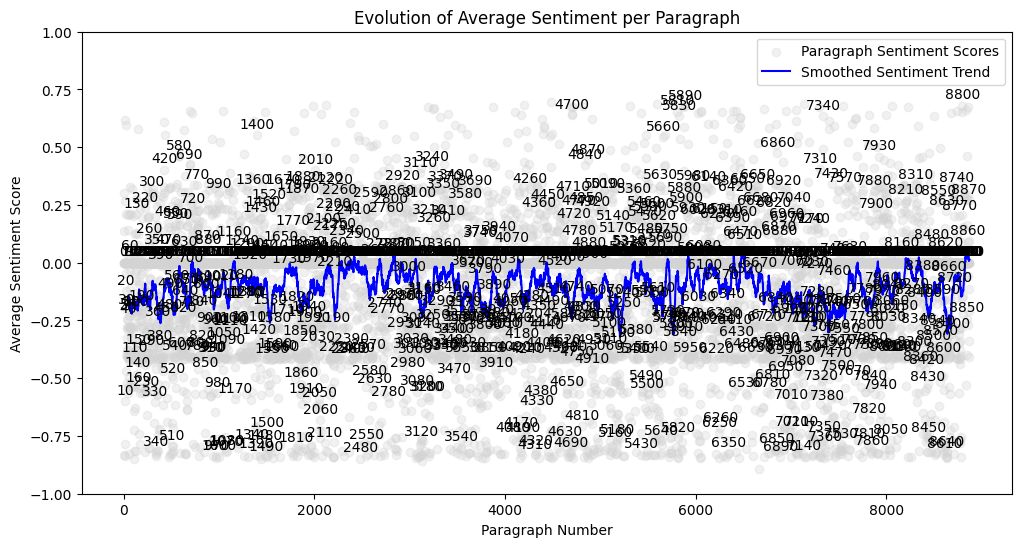

In [30]:
window_size = 50
smoothed_sentiments = np.convolve(paragraph_sentiments, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(12, 6))

plt.scatter(range(len(paragraph_sentiments)), paragraph_sentiments, alpha=0.3, color='lightgray', label='Paragraph Sentiment Scores')

plt.plot(range(window_size - 1, len(paragraph_sentiments)), smoothed_sentiments, color='blue', label='Smoothed Sentiment Trend')

plt.ylim(-1, 1)

plt.xlabel('Paragraph Number')
plt.ylabel('Average Sentiment Score')
plt.title('Evolution of Average Sentiment per Paragraph')
plt.legend()

for i, sentiment in enumerate(paragraph_sentiments):
    if i % 10 == 0:
        plt.annotate(str(i), (i, sentiment), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

In [31]:
def display_paragraphs(indices):
  for i in indices:
    if 0 <= i < len(paragraphs):
      print(f"Paragraph {i}:")
      for sentence in paragraphs[i]:
        print(sentence)
    else:
      print(f"Index {i} is out of bounds.")

display_paragraphs([4700])

Paragraph 4700:
Mais aujourd'hui il faut bien que je croie à l'excès de vos bontés, puisque non seulement votre lettre, mais encore votre suivante, m'affirme que j'ai le bonheur d'être aimé de vous.


In [32]:
display_paragraphs([8800])

Paragraph 8800:
Le jeune mousquetaire était en excellente disposition pour trépasser héroïquement.


In [36]:
display_paragraphs([2110])

Paragraph 2110:
Mme Bonacieux rougit.


In [40]:
display_paragraphs([340])

Paragraph 340:
Porthos comprit ou ne comprit pas, toujours est-il que, se laissant aller à sa colère :
